## Handle aggregated single cell data

First, open the annotated data.

In [1]:

%load_ext autoreload

%autoreload 2

import os
import yaml
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import re

In [2]:
folder = "C:/Users/amarx/Documents/Promotion/experiments/2021-01_growth_fixed_cells/data"

adata = ad.read_h5ad(os.path.join(folder, 'morph_data_agg.h5ad'))
adata

AnnData object with n_obs × n_vars = 720 × 3121
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Primarieswithoutborder_AreaShape_BoundingBoxArea', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_Y', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_Y', 'Primarieswithoutborder_AreaShape_Center_X', 'Primarieswithoutborder_AreaShape_Center_Y', 'Primarieswithoutborder_AreaShape_EulerNumber', 'Primarieswithoutborder_Children_Cells_Count', 'Primarieswithoutborder_Children_Cytoplasm_Count', 'Primarieswithoutborder_Children_Primaries_Count', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Actin', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Brightfield', 'Primarieswithoutborder_Location_CenterMassIntensity_X

In [3]:
from morphelia.preprocessing import *

adata = drop_nan(adata, verbose=True)
adata = drop_duplicates(adata, verbose=True)
adata = drop_all_equal(adata, verbose=True)
adata


Dropped NaN containing variables: ['Primarieswithoutborder_AreaShape_NormalizedMoment_0_0', 'Primarieswithoutborder_AreaShape_NormalizedMoment_0_1', 'Primarieswithoutborder_AreaShape_NormalizedMoment_1_0', 'Cells_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cells_AreaShape_NormalizedMoment_1_0', 'Cells_Neighbors_AngleBetweenNeighbors_20', 'Cells_Neighbors_AngleBetweenNeighbors_Adjacent', 'Cells_Neighbors_FirstClosestDistance_20', 'Cells_Neighbors_FirstClosestDistance_Adjacent', 'Cells_Neighbors_SecondClosestDistance_20', 'Cells_Neighbors_SecondClosestDistance_Adjacent', 'Cytoplasm_AreaShape_Area', 'Cytoplasm_AreaShape_CentralMoment_0_0', 'Cytoplasm_AreaShape_CentralMoment_0_1', 'Cytoplasm_AreaShape_CentralMoment_0_2', 'Cytoplasm_AreaShape_CentralMoment_0_3', 'Cytoplasm_AreaShape_CentralMoment_1_0', 'Cytoplasm_AreaShape_CentralMoment_1_1', 'Cytoplasm_AreaShape_CentralMoment_1_2', 'Cytoplasm_AreaShape_CentralMoment_1_3', 'Cytoplasm_AreaShape_CentralMoment_2_0

View of AnnData object with n_obs × n_vars = 720 × 2700
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Primarieswithoutborder_AreaShape_BoundingBoxArea', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_Y', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_Y', 'Primarieswithoutborder_AreaShape_Center_X', 'Primarieswithoutborder_AreaShape_Center_Y', 'Primarieswithoutborder_AreaShape_EulerNumber', 'Primarieswithoutborder_Children_Cells_Count', 'Primarieswithoutborder_Children_Cytoplasm_Count', 'Primarieswithoutborder_Children_Primaries_Count', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Actin', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Brightfield', 'Primarieswithoutborder_Location_CenterMassInt

The annotated data object shows 720 well with 3121 morphological features per well.
Let's show the plate layout for single plates and do some quality control:

C:\Users\amarx\PycharmProjects\Morphelia\morphelia\plotting\qc_plot.py:114: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("plasma"))
  cmap.set_bad("lightgrey")


(<Figure size 1080x504 with 2 Axes>, <AxesSubplot:>)

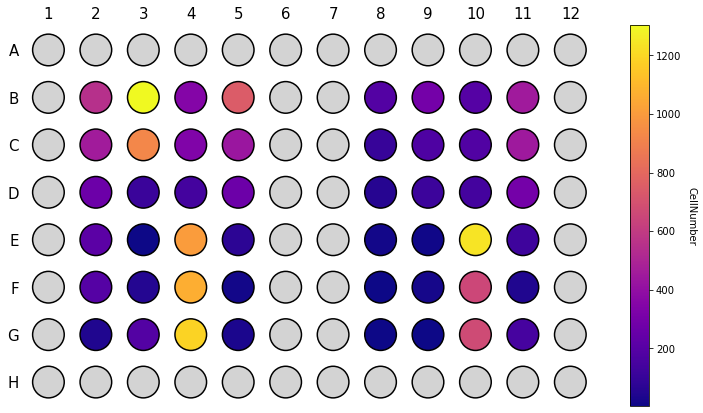

In [4]:
from morphelia.plotting import qc_plot

qc_plot(adata, wells=96, select={'BatchNumber': 3, 'PlateNumber': 5},
        color="CellNumber")

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Metadata_Time', ylabel='CellNumber'>)

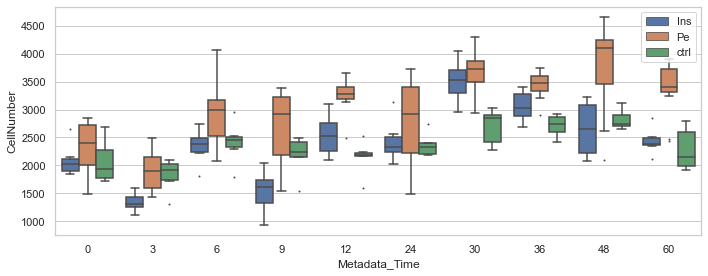

In [5]:
from morphelia.plotting import boxplot

boxplot(adata[adata.obs['BatchNumber'] == 2], x="Metadata_Time",
        y="CellNumber",
        hue="Metadata_Treatment")

### Preprocessing

Now we do some preprocessing of the data and filter highly variable features.
First, drop features with invalid values.

Correct for batch effects.

In [16]:
adata.obs

,BatchNumber,PlateNumber,ImageNumber,ObjectNumber,Metadata_Col,Metadata_Field,Metadata_FileLocation,Metadata_Frame,Metadata_Row,Metadata_Series,...,Cytoplasm_Location_MaxIntensity_Z_DNA,Cytoplasm_Location_MaxIntensity_Z_Desmin,Cytoplasm_Location_MaxIntensity_Z_PC,Cytoplasm_Number_Object_Number,Cytoplasm_Parent_Cells,Cytoplasm_Parent_Primarieswithoutborder,Metadata_Treatment,Metadata_Dosis,Metadata_t,batch
0-0,1,1,1,1,2,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,ctrl,NaN,0,0
1-0,1,1,26,1,3,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,Pe,med,0,0
2-0,1,1,51,1,4,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,Ins,low,0,0
3-0,1,1,91,1,5,16,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,Ins,high,0,0
4-0,1,1,101,1,8,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,ctrl,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43-14,3,4,1076,1,5,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,Ins,med,6,14
44-14,3,4,1101,1,8,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,ctrl,NaN,7,14
45-14,3,4,1126,1,9,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,Pe,low,7,14
46-14,3,4,1151,1,10,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,Pe,high,7,14


In [27]:
sc.pp.combat(adata, key='BatchNumber')


In [28]:
[var for var in adata.var.index if "MeanIntensity" in var or "AreaShape_Area" in var]

['Cells_Intensity_MeanIntensityEdge_DNA',
 'Cytoplasm_Intensity_MeanIntensity_DNA',
 'Cells_Intensity_MeanIntensityEdge_Actin',
 'Cytoplasm_Intensity_MeanIntensityEdge_DNA',
 'Cytoplasm_Intensity_MeanIntensityEdge_Actin',
 'Cells_Intensity_MeanIntensityEdge_Desmin',
 'Cells_Intensity_MeanIntensity_DNA',
 'Cytoplasm_Intensity_MeanIntensity_Actin',
 'Cells_Intensity_MeanIntensity_Actin',
 'Primarieswithoutborder_Intensity_MeanIntensityEdge_DNA',
 'Cytoplasm_Intensity_MeanIntensityEdge_Desmin',
 'Primarieswithoutborder_Intensity_MeanIntensity_Actin',
 'Primarieswithoutborder_Intensity_MeanIntensityEdge_Actin',
 'Primarieswithoutborder_Intensity_MeanIntensity_Desmin',
 'Cells_Intensity_MeanIntensity_Desmin',
 'Cytoplasm_Intensity_MeanIntensity_Desmin',
 'Primarieswithoutborder_Intensity_MeanIntensityEdge_Desmin',
 'Primarieswithoutborder_Intensity_MeanIntensity_DNA',
 'Cells_Intensity_MeanIntensityEdge_Brightfield',
 'Cytoplasm_Intensity_MeanIntensityEdge_Brightfield',
 'Cytoplasm_Intensit

We dropped around 100 features.

Now logarithmize and scale the data.

In [7]:
sc.pp.log1p(adata)
adata = min_max_scaler(adata)

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\preprocessing\_simple.py:375: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\preprocessing\_simple.py:354: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [32]:
np.isnan(adata.X)

array([[ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True]])

In [9]:
adata = drop_nan(adata, verbose=True)
adata

Dropped NaN containing variables: ['Cells_AreaShape_CentralMoment_1_3', 'Primarieswithoutborder_AreaShape_CentralMoment_1_3', 'Cells_AreaShape_CentralMoment_1_2', 'Cells_AreaShape_CentralMoment_1_1', 'Primarieswithoutborder_AreaShape_CentralMoment_1_2', 'Primarieswithoutborder_AreaShape_CentralMoment_1_1', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_DNA_2_0', 'Cells_RadialDistribution_ZernikePhase_Brightfield_2_0', 'Cells_RadialDistribution_ZernikePhase_DNA_2_0', 'Cells_RadialDistribution_ZernikePhase_Actin_2_0', 'Cells_RadialDistribution_ZernikePhase_Desmin_2_0', 'Cells_RadialDistribution_ZernikePhase_PC_2_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_PC_2_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_Brightfield_2_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_Actin_2_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_Brightfield_4_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_PC_4_0', 'Primarieswithoutborder

View of AnnData object with n_obs × n_vars = 720 × 2546
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Primarieswithoutborder_AreaShape_BoundingBoxArea', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_Y', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_Y', 'Primarieswithoutborder_AreaShape_Center_X', 'Primarieswithoutborder_AreaShape_Center_Y', 'Primarieswithoutborder_AreaShape_EulerNumber', 'Primarieswithoutborder_Children_Cells_Count', 'Primarieswithoutborder_Children_Cytoplasm_Count', 'Primarieswithoutborder_Children_Primaries_Count', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Actin', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Brightfield', 'Primarieswithoutborder_Location_CenterMassInt

We lost again some features.
Now we visualize all features as a heatmap.


Now we identify highly variable features:

In [10]:
sc.pp.highly_variable_genes(adata)

Trying to set attribute `.uns` of view, copying.


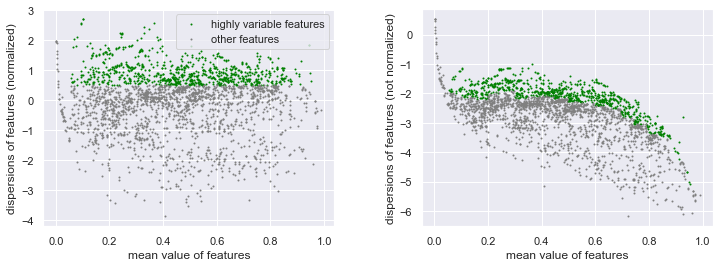

In [11]:
from morphelia.extern import highly_variable_genes

highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the scaled and logarithmized raw feature space
for later use in differential testing and visualizations. Thit simply freezes the state of the
AnnData object.

In [12]:
adata.raw = adata

Actually do the filtering

In [13]:
adata = adata[:, adata.var.highly_variable]

Now we scale each feature to unit variance

In [14]:
adata = z_transform(adata)
adata

View of AnnData object with n_obs × n_vars = 720 × 822
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Primarieswithoutborder_AreaShape_BoundingBoxArea', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_Y', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_Y', 'Primarieswithoutborder_AreaShape_Center_X', 'Primarieswithoutborder_AreaShape_Center_Y', 'Primarieswithoutborder_AreaShape_EulerNumber', 'Primarieswithoutborder_Children_Cells_Count', 'Primarieswithoutborder_Children_Cytoplasm_Count', 'Primarieswithoutborder_Children_Primaries_Count', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Actin', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Brightfield', 'Primarieswithoutborder_Location_CenterMassInte

### Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA),
which reveals the main axes of variation and denoises the data.

In [15]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

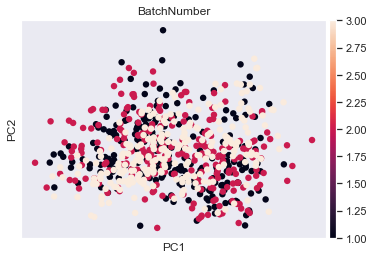

In [16]:
sc.pl.pca(adata, color='BatchNumber')

Let us inspect the contribution of single PCs to the total variance in the data.
This gives us information about how many PCs we should consider in order to
compute the neighborhood relations of cells, e.g. used in the clustering
function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough
estimate of the number of PCs does fine.

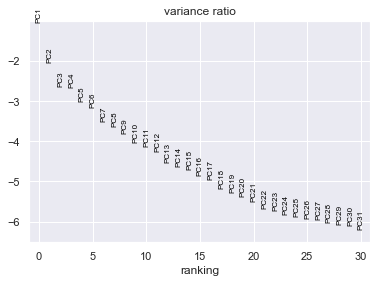

In [42]:
sc.pl.pca_variance_ratio(adata, log=True)

### Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA
representation of the data matrix. You might simply use default values here.

In [28]:
adata

AnnData object with n_obs × n_vars = 720 × 827
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Primarieswithoutborder_AreaShape_BoundingBoxArea', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_Y', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_Y', 'Primarieswithoutborder_AreaShape_Center_X', 'Primarieswithoutborder_AreaShape_Center_Y', 'Primarieswithoutborder_AreaShape_EulerNumber', 'Primarieswithoutborder_Children_Cells_Count', 'Primarieswithoutborder_Children_Cytoplasm_Count', 'Primarieswithoutborder_Children_Primaries_Count', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Actin', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Brightfield', 'Primarieswithoutborder_Location_CenterMassIntensity_X_

In [43]:
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=30)

### Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below.
It is potentially more faithful to the global connectivity of the manifold
than tSNE, i.e., it better preserves trajectories.
In some ocassions, you might still observe disconnected clusters and
similar connectivity violations. They can usually be remedied by running:

In [44]:
sc.tl.umap(adata)

In [25]:
adata.obs

,BatchNumber,PlateNumber,ImageNumber,ObjectNumber,Metadata_Col,Metadata_Field,Metadata_FileLocation,Metadata_Frame,Metadata_Row,Metadata_Series,...,Cytoplasm_Location_MaxIntensity_Z_DNA,Cytoplasm_Location_MaxIntensity_Z_Desmin,Cytoplasm_Location_MaxIntensity_Z_PC,Cytoplasm_Number_Object_Number,Cytoplasm_Parent_Cells,Cytoplasm_Parent_Primarieswithoutborder,Metadata_Treatment,Metadata_Dosis,Metadata_t,batch
0-0,1,1,1,1,2,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,ctrl,NaN,0,0
1-0,1,1,26,1,3,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,Pe,med,0,0
2-0,1,1,51,1,4,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,Ins,low,0,0
3-0,1,1,91,1,5,16,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,Ins,high,0,0
4-0,1,1,101,1,8,1,NaN,0,B,0,...,0.0,0.0,0.0,1,1,1,ctrl,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43-14,3,4,1076,1,5,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,Ins,med,6,14
44-14,3,4,1101,1,8,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,ctrl,NaN,7,14
45-14,3,4,1126,1,9,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,Pe,low,7,14
46-14,3,4,1151,1,10,1,NaN,0,G,0,...,0.0,0.0,0.0,1,1,1,Pe,high,7,14


In [45]:
pe_dict = {
    'ctrl': '0',
    'Pe': '1',
    'Ins': '0'
}

ins_dict = {
    'ctrl': '0',
    'Pe': '0',
    'Ins': '1'
}


adata.obs['Metadata_Treatment_Pe'] = adata.obs['Metadata_Treatment'].map(pe_dict).astype(int)
adata.obs['Metadata_Treatment_Ins'] = adata.obs['Metadata_Treatment'].map(ins_dict).astype(int)


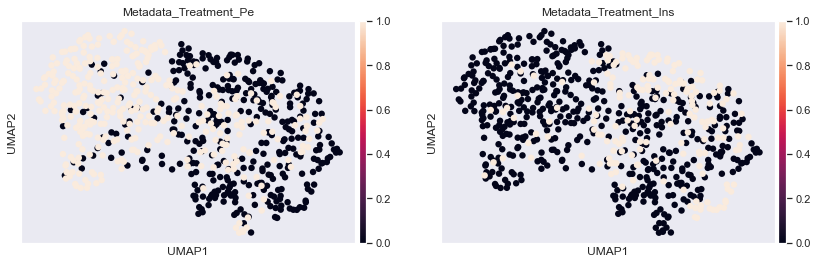

In [49]:
sc.pl.umap(adata, color=['Metadata_Treatment_Pe', 'Metadata_Treatment_Ins'])

### Trajectory


In [50]:
import scanpy.external as sce
import pandas as pd

In [52]:
adata.obs['Metadata_t_Cat'] = pd.Categorical(adata.obs['Metadata_Time'].astype(str),
                                             categories=list(adata.obs['Metadata_Time'].astype(str).unique()))

In [53]:
sce.tl.harmony_timeseries(adata, tp='Metadata_t_Cat', n_components=50)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Running PCA with 13 components
Nearest neighbor computation...


C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:70: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  kNN = temp.uns['neighbors']['distances']
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)


Constucting affinities between 0 and 3...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 3 and 6...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 6 and 9...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 9 and 12...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 12 and 24...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 24 and 48...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 48 and 60...
t+1 neighbors of t...
t neighbors of t+1...


C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)


Constucting affinities between 60 and 30...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 30 and 36...
t+1 neighbors of t...
t neighbors of t+1...


C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:130: RuntimeWarning: divide by zero encountered in true_divide
  dists = dists ** 2/(scaling_factors.values[rows] ** 2)
100%|██████████| 500/500 [00:09<00:00, 50.13it/s]

BarnesHut Approximation  took  1.58  seconds
Repulsion forces  took  7.32  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.38  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


In [54]:
adata

AnnData object with n_obs × n_vars = 720 × 950
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Primarieswithoutborder_AreaShape_BoundingBoxArea', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMaximum_Y', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_X', 'Primarieswithoutborder_AreaShape_BoundingBoxMinimum_Y', 'Primarieswithoutborder_AreaShape_Center_X', 'Primarieswithoutborder_AreaShape_Center_Y', 'Primarieswithoutborder_AreaShape_EulerNumber', 'Primarieswithoutborder_Children_Cells_Count', 'Primarieswithoutborder_Children_Cytoplasm_Count', 'Primarieswithoutborder_Children_Primaries_Count', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Actin', 'Primarieswithoutborder_Location_CenterMassIntensity_X_Brightfield', 'Primarieswithoutborder_Location_CenterMassIntensity_X_

In [55]:
sce.tl.palantir(adata,
                n_components=30,
                knn=30,
                use_adjacency_matrix=True,
                distances_key='harmony_aff_aug')

In [56]:
sc.tl.tsne(adata, use_rep='X_palantir_multiscale')

In [60]:
adata.obs['Metadata_Treatment']

0-0      ctrl
1-0        Pe
2-0        Pe
3-0       Ins
4-0      ctrl
         ... 
43-14     Ins
44-14    ctrl
45-14      Pe
46-14      Pe
47-14     Ins
Name: Metadata_Treatment, Length: 720, dtype: category
Categories (3, object): ['Ins', 'Pe', 'ctrl']

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


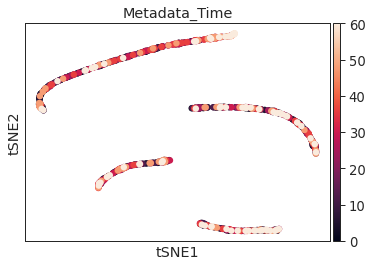

In [61]:
sc.pl.tsne(adata, color="Metadata_Time")

### Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster.
For this, by default, the .raw attribute of AnnData is used in case it has been initialized before.
The simplest and fastest method to do so is the t-test.
Here we use the Wilcoxon rank test.

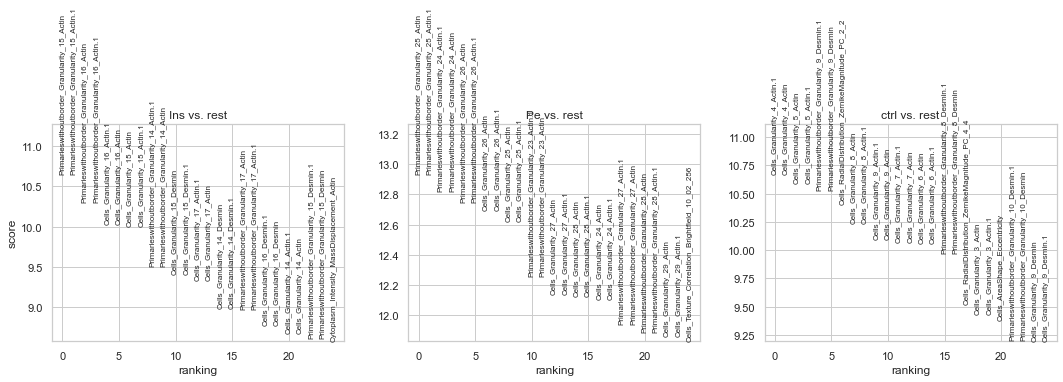

In [19]:
sc.tl.rank_genes_groups(adata, 'Metadata_Treatment', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [24]:
marker_feats = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


Get a table with the scores and groups.


In [21]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,Ins_n,Ins_p,Pe_n,Pe_p,ctrl_n,ctrl_p
0,Primarieswithoutborder_Granularity_15_Actin,1.675420e-26,Primarieswithoutborder_Granularity_25_Actin,2.839016e-38,Cells_Granularity_4_Actin.1,1.359705e-26
1,Primarieswithoutborder_Granularity_15_Actin.1,1.675420e-26,Primarieswithoutborder_Granularity_25_Actin.1,2.839016e-38,Cells_Granularity_4_Actin,1.359705e-26
2,Primarieswithoutborder_Granularity_16_Actin,6.285036e-25,Primarieswithoutborder_Granularity_24_Actin.1,1.179605e-37,Cells_Granularity_5_Actin,3.118397e-26
3,Primarieswithoutborder_Granularity_16_Actin.1,6.285036e-25,Primarieswithoutborder_Granularity_24_Actin,1.179605e-37,Cells_Granularity_5_Actin.1,3.118397e-26
4,Cells_Granularity_16_Actin.1,1.145591e-23,Primarieswithoutborder_Granularity_26_Actin,3.035626e-37,Primarieswithoutborder_Granularity_9_Desmin.1,6.286561e-26


Now we store the features with high scores as marker genes


In [29]:
marker_feats = marker_feats.to_numpy().flatten().tolist()

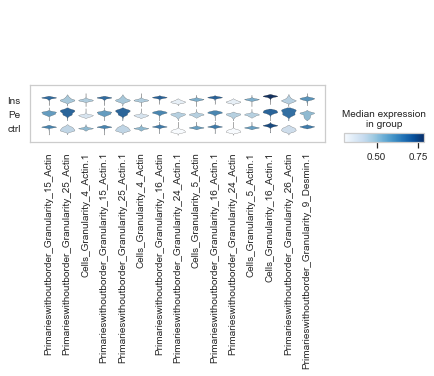

In [31]:
sc.pl.stacked_violin(adata, marker_feats, groupby='Metadata_Treatment', rotation=90)


In [ ]:
adata[:, ['Metadata-t']]